# Introduction to Machine Learning: Course Project

**Project description**

Mobile carrier Megaline has found out that many of their subscribers use legacy plans. They want to develop a model that would analyze subscribers' behavior and recommend one of Megaline's newer plans: Smart or Ultra.

You have access to behavior data about subscribers who have already switched to the new plans (from the project for the Statistical Data Analysis course). For this classification task, you need to develop a model that will pick the right plan. Since you’ve already performed the data preprocessing step, you can move straight to creating the model.

Develop a model with the highest possible accuracy. In this project, the threshold for accuracy is 0.75. Check the accuracy using the test dataset.

**Project instructions**
1. Open and look through the data file. Path to the file:datasets/users_behavior.csv
2. Split the source data into a training set, a validation set, and a test set.
3. Investigate the quality of different models by changing hyperparameters. Briefly describe the findings of the study.
4. Check the quality of the model using the test set.
5. Additional task: sanity check the model. This data is more complex than what you’re used to working with, so it's not an easy task. We'll take a closer look at it later.

**Project evaluation**
- How did you look into data after downloading?
- Have you correctly split the data into train, validation, and test sets?
- How have you chosen the sets' sizes?
- Did you evaluate the quality of the models correctly?
- What models and hyperparameters did you use?
- What are your findings?
- Did you test the models correctly?
- What is your accuracy score?
- Have you stuck to the project structure and kept the code neat?

**Dataset and Project Context:**
- We are developing a model for Megaline to recommend one of 2 plans: Smart or Ultra
- The data is of users who have switched to one of these new plans (1 is_ultra = Ultra, 0 is_ultra = Smart)
- The data is already preprocessed, so we can start directly with the model
- The features are 
    - calls: number of calls made
    - minutes: total minutes used
    - messages: number of texts
    - mb_used: internet used in mb 
- Goal: Develop a model with the highest possible accuracy. In this project, the threshold for accuracy is 0.75. Check the accuracy using the test dataset.

**Initial Observations:**
- This is going to be a classification problem, whether or not a user is on the ultra plan
- Looks like we have target data for all ~3,200 observations, so we will have to create a test set 
    - We will split with the standard ratio of 3:1:1 (60%, 20%, 20% of the data each) to start
- Check the distributions of each feature 
- Based on usage patterns, we can group users into Ultra (1) or Smart (0) using the is_ultra target feature 

**Modeling Thoughts:**
- We will need a simple baseline model. Logistic regression is great because this is a classification problem. 
- We can then use descision tree classifier and random forest classifiers
- Maybe use cross validation to see what different cuts of the data do

## Data Preparation and EDA 

In [1]:
# Import modules
import pandas as pd
import seaborn as sns
from scipy import stats as st
from matplotlib import pyplot as plt
import matplotlib.ticker as mtick
import joblib

# Classification models
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression # Baseline model
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Evaluation modules
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import mean_squared_error

In [2]:
# Load the data
users_df = pd.read_csv('users_behavior.csv')

In [3]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [4]:
# Not necessary but changing these 2 to int since there aren't partial calls or messages
users_df['calls'] = users_df['calls'].astype('int')
users_df['messages'] = users_df['messages'].astype('int')

In [5]:
users_df.describe()

,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


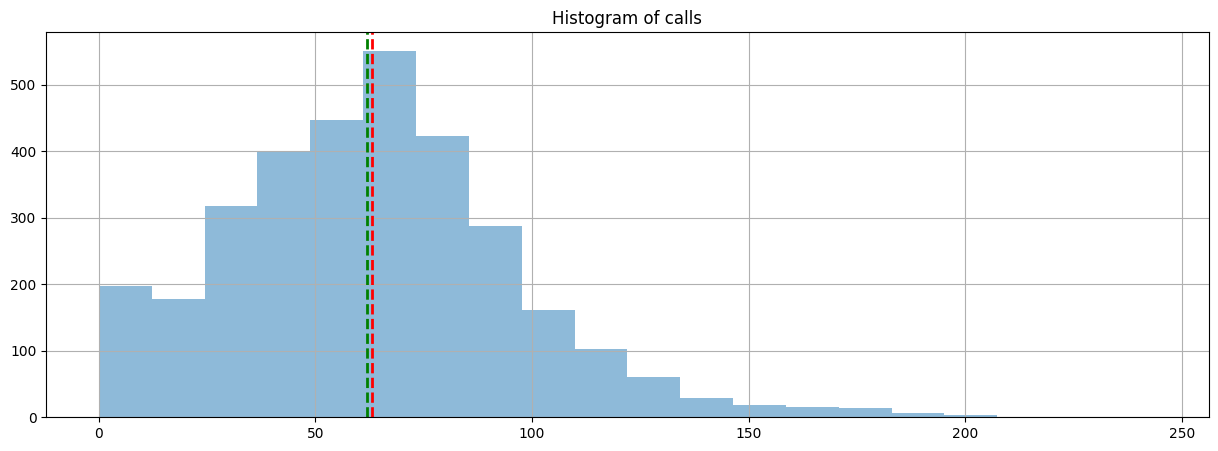

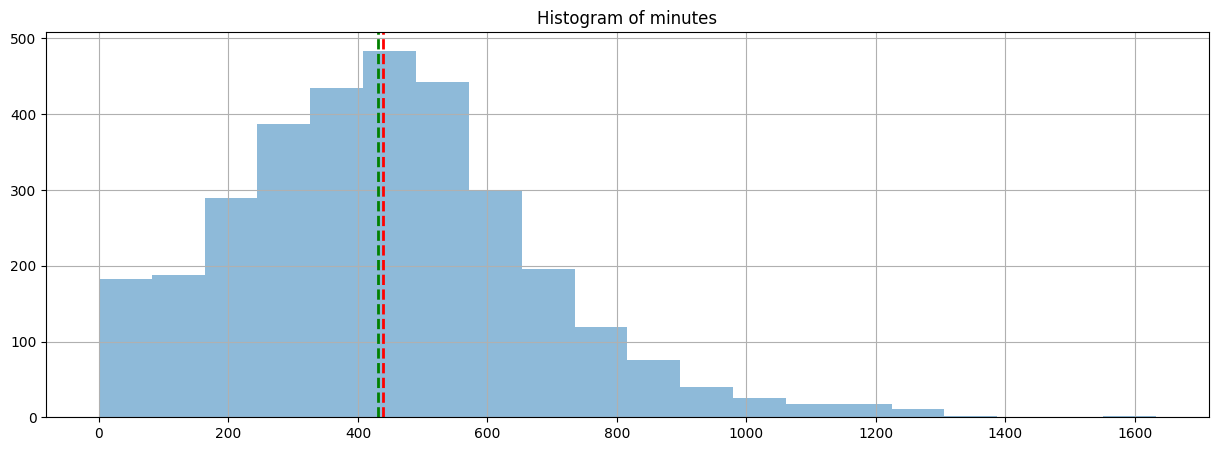

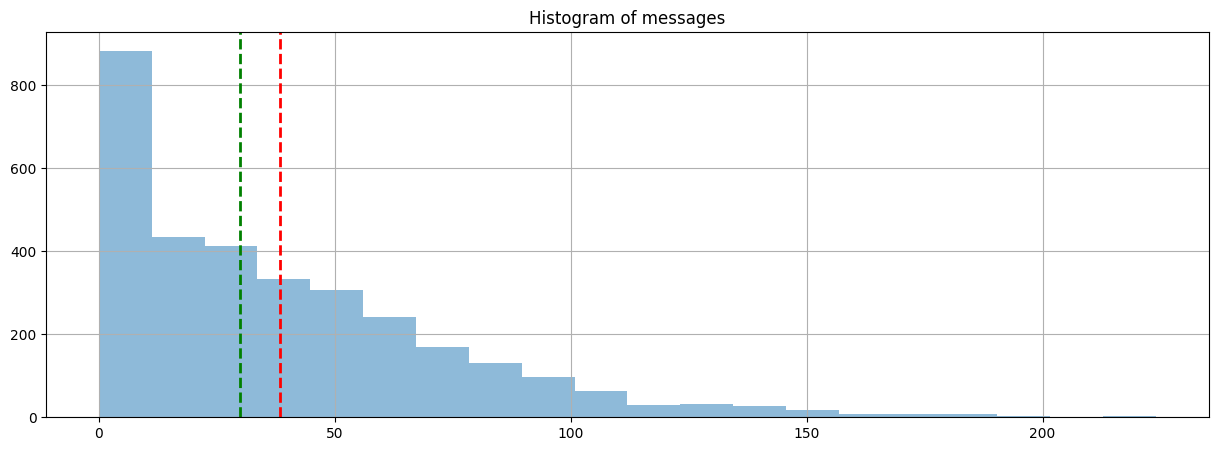

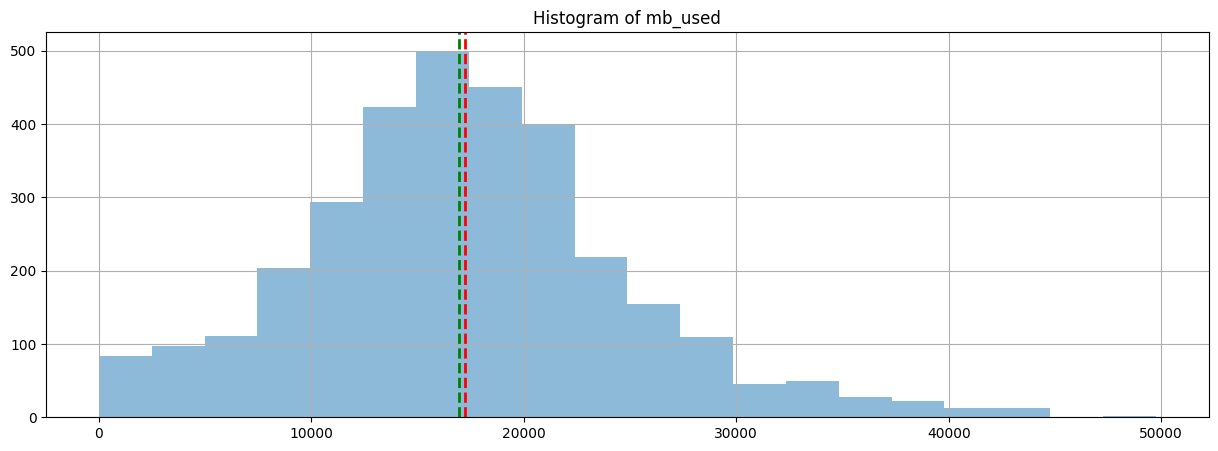

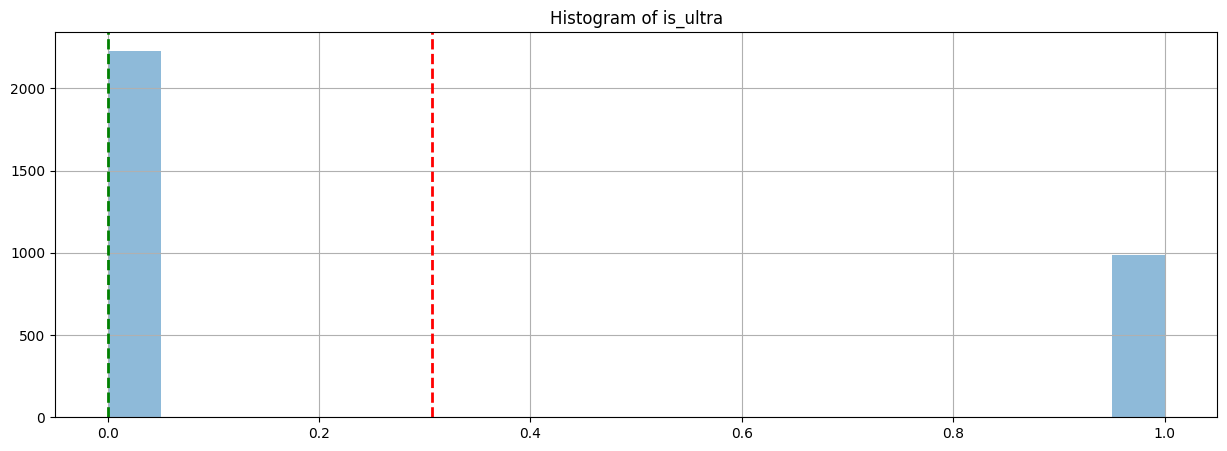

In [6]:
# Checking distribution of data

features = users_df.columns.tolist()

for feature in features:
    users_df[feature].hist(figsize=[15,5], bins=20, alpha=0.5)
    plt.axvline(users_df[feature].mean(), color='red', linestyle='--', linewidth=2)
    plt.axvline(users_df[feature].median(), color='green', linestyle='--', linewidth=2)
    plt.title(f"Histogram of {feature}")
    plt.show()

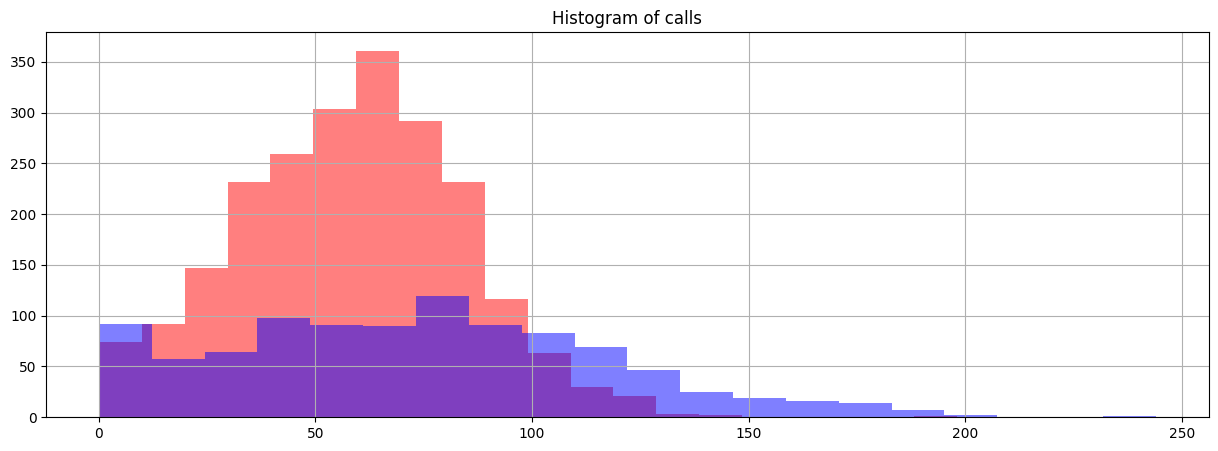

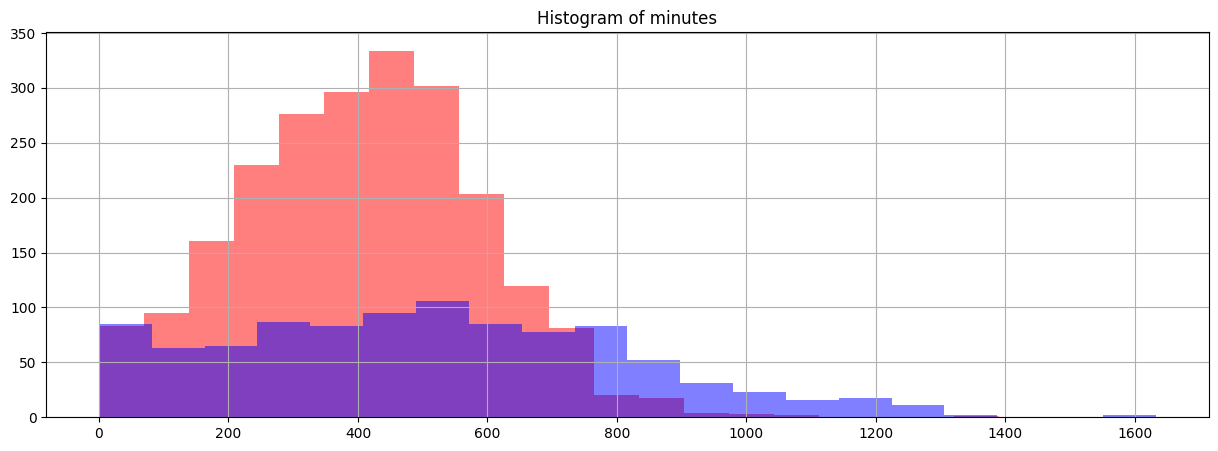

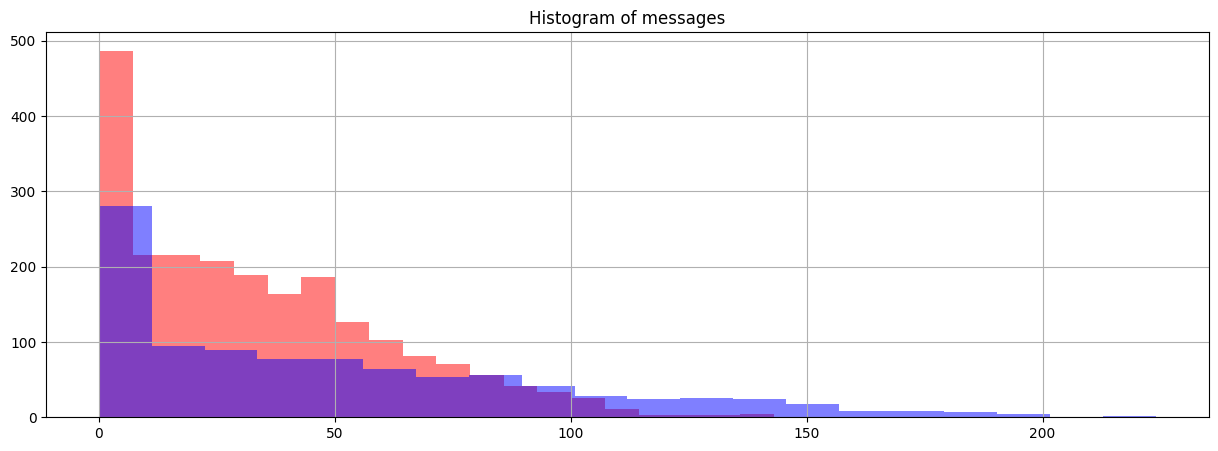

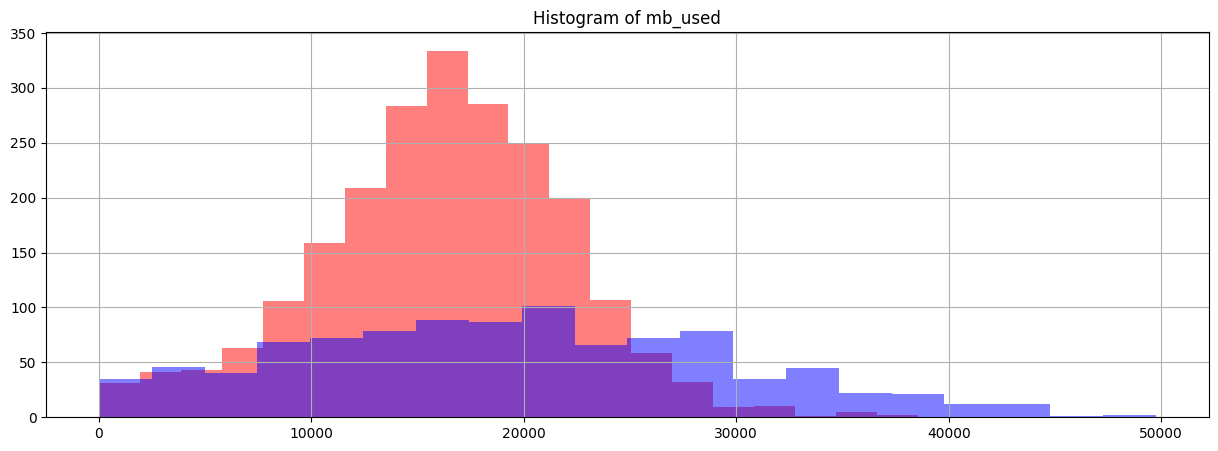

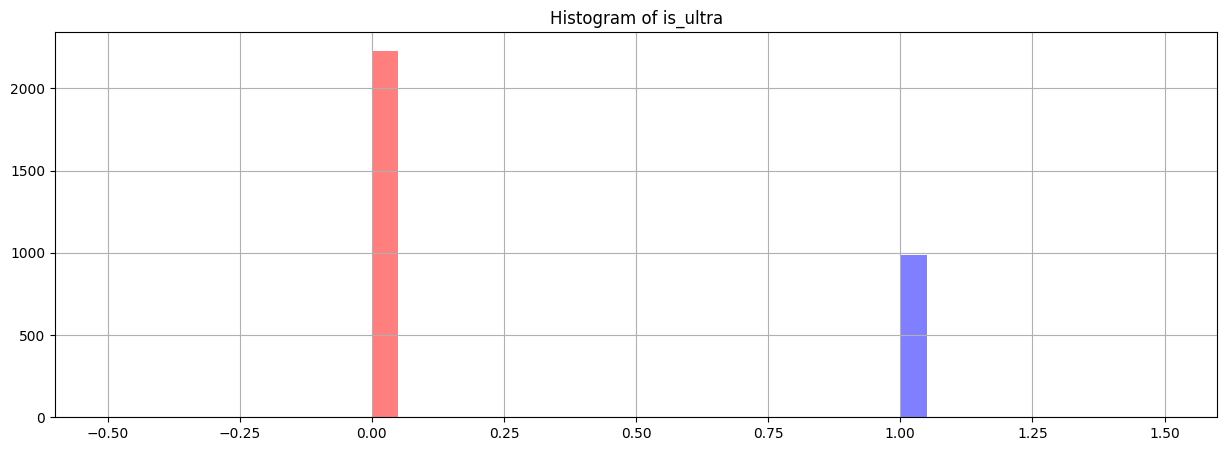

In [7]:
# Checking distribution of data by plan 
#     The distributions of the two datasets are very different 
#     Ultra users are far more distributed in their usage, with a longer right tail 
#     This could also imply many current Ultra users may be better off on Smart if their usage isn't as high as the right-tails that pull the average up 

features = users_df.columns.tolist()

for feature in features:
    users_df.query('is_ultra == 0')[feature].hist(figsize=[15,5], bins=20, color='r', alpha=0.5)
    users_df.query('is_ultra == 1')[feature].hist(figsize=[15,5], bins=20, color='b', alpha=0.5)
    plt.title(f"Histogram of {feature}")
    plt.show()

In [8]:
# Roughly 70% / 30% split for Smart vs. Ultra

users_df['is_ultra'].value_counts(normalize=True)

is_ultra
0    0.693528
1    0.306472
Name: proportion, dtype: float64

In [9]:
# Looking at descriptive stats of Smart users

print('Smart Users:')
print(users_df.query('is_ultra == 0').describe())
print()
print('Difference vs. All Users')
print(users_df.query('is_ultra == 0').describe() - users_df.describe())

Smart Users:
             calls      minutes     messages       mb_used  is_ultra
count  2229.000000  2229.000000  2229.000000   2229.000000    2229.0
mean     58.463437   405.942952    33.384029  16208.466949       0.0
std      25.939858   184.512604    28.227876   5870.498853       0.0
min       0.000000     0.000000     0.000000      0.000000       0.0
25%      40.000000   274.230000    10.000000  12643.050000       0.0
50%      60.000000   410.560000    28.000000  16506.930000       0.0
75%      76.000000   529.510000    51.000000  20043.060000       0.0
max     198.000000  1390.220000   143.000000  38552.620000       0.0

Difference vs. All Users
            calls     minutes    messages       mb_used    is_ultra
count -985.000000 -985.000000 -985.000000   -985.000000 -985.000000
mean    -4.575456  -32.265835   -4.897241   -999.206887   -0.306472
std     -7.296509  -50.057268   -7.920450  -1700.469393   -0.461100
min      0.000000    0.000000    0.000000      0.000000    0.000000


In [10]:
# Looking at descriptive stats of Ultra users

print('Ultra Users:')
print(users_df.query('is_ultra == 1').describe())
print()
print('Difference vs. All Users')
print(users_df.query('is_ultra == 1').describe() - users_df.describe())

Ultra Users:
            calls      minutes    messages       mb_used  is_ultra
count  985.000000   985.000000  985.000000    985.000000     985.0
mean    73.392893   511.224569   49.363452  19468.823228       1.0
std     43.916853   308.031100   47.804457  10087.178654       0.0
min      0.000000     0.000000    0.000000      0.000000       1.0
25%     41.000000   276.030000    6.000000  11770.280000       1.0
50%     74.000000   502.550000   38.000000  19308.010000       1.0
75%    104.000000   730.050000   79.000000  26837.720000       1.0
max    244.000000  1632.060000  224.000000  49745.730000       1.0

Difference vs. All Users
             calls      minutes     messages      mb_used     is_ultra
count -2229.000000 -2229.000000 -2229.000000 -2229.000000 -2229.000000
mean     10.354001    73.015782    11.082182  2261.149392     0.693528
std      10.680486    73.461228    11.656132  2516.210408    -0.461100
min       0.000000     0.000000     0.000000     0.000000     1.000000
25%

## Predictive Models
- Using Logistic Regression as a baseline model, comparing it to decision tree and random forest
- Random forest should have the highest accuracy given it's use of multiple decision trees
- We use accuracy, recall, and precision, as well as F1 (harmonic mean of recall and precision) to evaluate the models
- We can also use k-fold cross validation to make sure we are getting a representative score to evaluate 

### Model Preprocessing
- The results from the first iterations of these models weren't great
- Going to standardize the features, since not all have normal distributions (i.e. messages), and they all have different scales
    - This applies only for the Logistic Regression, as decision trees aren't impacted by scaling
    - Scale only for models sensitive to variance in data

In [11]:
# Set the training size and random states here
train_size = 0.6
random_state = 8

In [12]:
# First split the data into training, validation, and test sets

X = users_df.drop(columns = ['is_ultra'])
y = users_df['is_ultra']

# Split the data into two sets: training and validation & test
X_train, X_rest, y_train, y_rest = train_test_split(X, y, train_size = train_size)

# Split the "rest" into equal sized validation and test sets
X_valid, X_test, y_valid, y_test = train_test_split(X_rest, y_rest, test_size=0.5)

print(X_train.shape), print(y_train.shape)
print(X_valid.shape), print(y_valid.shape)
print(X_test.shape), print(y_test.shape)

(1928, 4)
(1928,)
(643, 4)
(643,)
(643, 4)
(643,)


(None, None)

In [13]:
# Create a scaled version of the training data using StandardScaler
#     Logistic Regression is an optimization based algo and may perform better with scaled data
#     Note: Only use it on the training data to prevent data leakage 

scaler = StandardScaler()

X_train_scaled = pd.DataFrame(data=scaler.fit_transform(X_train), columns=X_train.columns)
X_valid_scaled = pd.DataFrame(data=scaler.transform(X_valid), columns=X_valid.columns)
X_test_scaled = pd.DataFrame(data=scaler.transform(X_test), columns=X_test.columns)

In [14]:
def print_eval_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    
    print('Accuracy:', f'{accuracy:.1%}')
    print('Recall:', f'{recall:.1%}')
    print('Precision:', f'{precision:.1%}')
    print('F1 Score:', f'{f1:.1%}')    

In [15]:
def print_results_distribution(y_pred):
    num = pd.Series(y_pred).value_counts()
    pct = pd.Series(y_pred).value_counts(normalize=True)
    print(pd.concat([num, pct], axis=1))

### Logistic Regression - Baseline Model

In [16]:
# Logistic Regression Model
#     Looks like it's just around the 75% accuracy cutoff 
#     On the other hand, recall (how many actual Ultra users were truly predicted) was very low  
#     Precision (how many of the predicted Ultra users were actually Ultra) was higher 

model0 = LogisticRegression(random_state=random_state, max_iter=1000)
model0.fit(X_train, y_train)

model0_train_pred = model0.predict(X_train)
model0_valid_pred = model0.predict(X_valid)

print('Training Set:')
print_eval_metrics(y_train, model0_train_pred)
print()
print('Validation Set:')
print_eval_metrics(y_valid, model0_valid_pred)

Training Set:
Accuracy: 74.6%
Recall: 22.9%
Precision: 83.5%
F1 Score: 35.9%

Validation Set:
Accuracy: 72.9%
Recall: 22.0%
Precision: 80.7%
F1 Score: 34.6%


In [17]:
# Taking a peek inside actual predictions:

print('Training Predictions:')
print_results_distribution(model0_train_pred)
print()
print('Validation Predictions:')
print_results_distribution(model0_valid_pred)

Training Predictions:
   count  proportion
0   1764    0.914938
1    164    0.085062

Validation Predictions:
   count  proportion
0    586    0.911353
1     57    0.088647


In [18]:
model0_scaled = LogisticRegression(random_state=random_state, max_iter=1000)
model0_scaled.fit(X_train_scaled, y_train)

model0_train_scaled_pred = model0_scaled.predict(X_train_scaled)
model0_valid_scaled_pred = model0_scaled.predict(X_valid_scaled)

print('Training Set:')
print_eval_metrics(y_train, model0_train_scaled_pred)
print()
print('Validation Set:')
print_eval_metrics(y_valid, model0_valid_scaled_pred)

Training Set:
Accuracy: 74.6%
Recall: 22.7%
Precision: 83.4%
F1 Score: 35.7%

Validation Set:
Accuracy: 73.1%
Recall: 22.0%
Precision: 82.1%
F1 Score: 34.7%


In [19]:
# Taking a peek inside actual predictions for scaled set:

print('Training Predictions:')
print_results_distribution(model0_train_scaled_pred)
print()
print('Validation Predictions:')
print_results_distribution(model0_valid_scaled_pred)

Training Predictions:
   count  proportion
0   1765    0.915456
1    163    0.084544

Validation Predictions:
   count  proportion
0    587    0.912908
1     56    0.087092


In [20]:
# Using cross validation to check if different cuts of the data impact scores

metrics = ['accuracy', 'recall', 'precision']

for metric in metrics:
    scores = cross_val_score(model0, X_train, y_train, cv=5, scoring=metric)
    print(f'{metric} scores:', scores)
    print(f'{metric} scores average:', f'{scores.mean():.1%}')
    print()

accuracy scores: [0.74352332 0.68911917 0.74870466 0.6961039  0.68831169]
accuracy scores average: 71.3%

recall scores: [0.20833333 0.00833333 0.25833333 0.03361345 0.01666667]
recall scores average: 10.5%

precision scores: [0.86206897 0.5        0.79487179 0.66666667 0.5       ]
precision scores average: 66.5%



**Observation:** 
- The reason recall is so low is because the model is overpredicting is_ultra = 0 since that's the majority. The issue can be seen in the histograms, a large portion of the ultra users overlap with smart characteristics.  
- This means most of the errors are from incorrectly categorizing Ultra users as Smart users.
- For the 5-fold cross validation, results are in the same range except for precision which makes sense if the model is underpredicting ultra users (higher sensitivity due to lower number of predictions)
- We can verify this by plotting a histogram of the predicted features and results

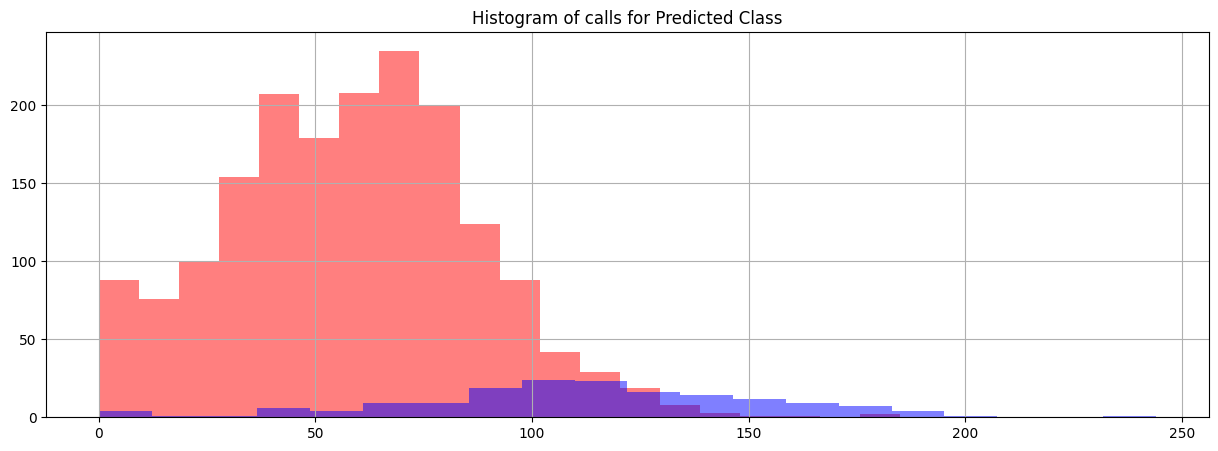

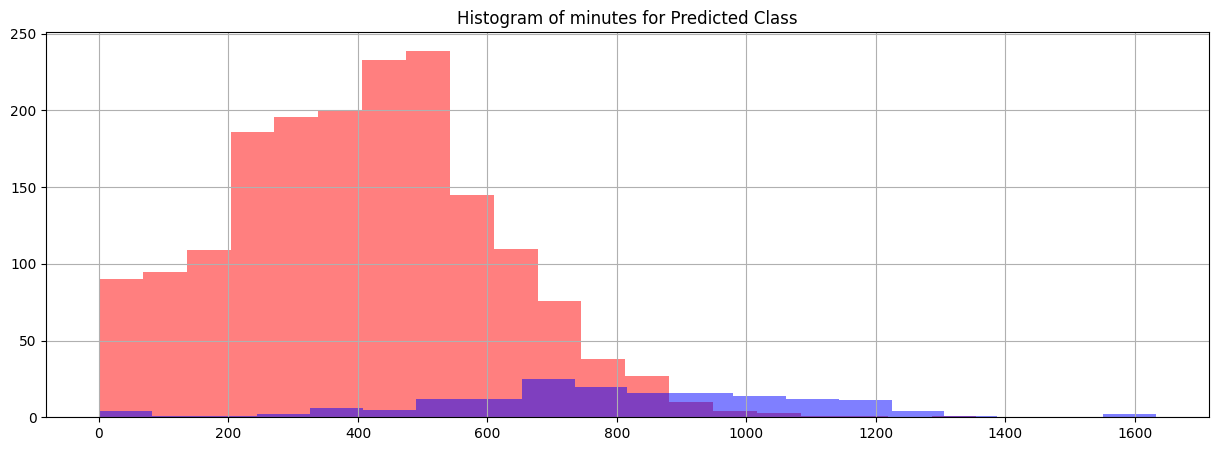

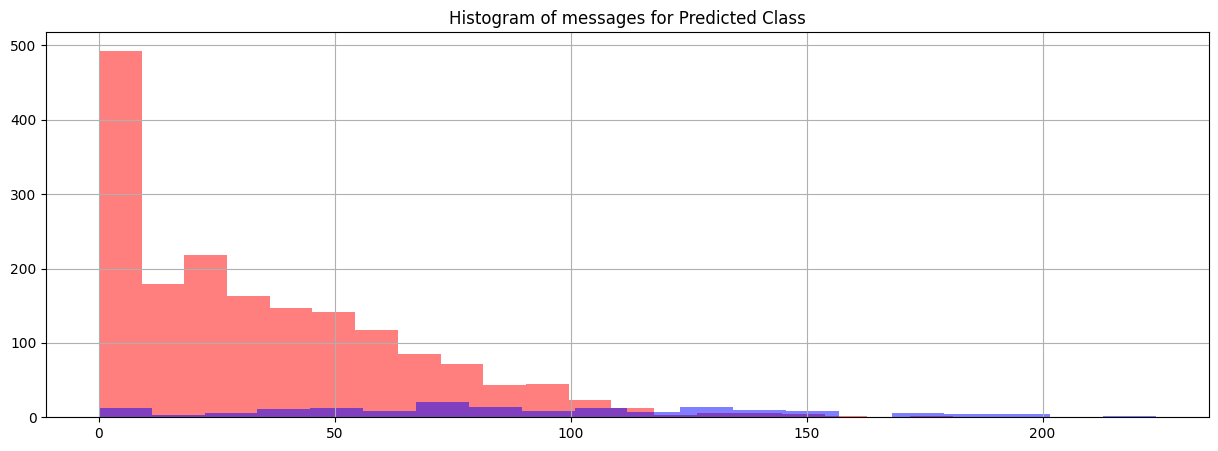

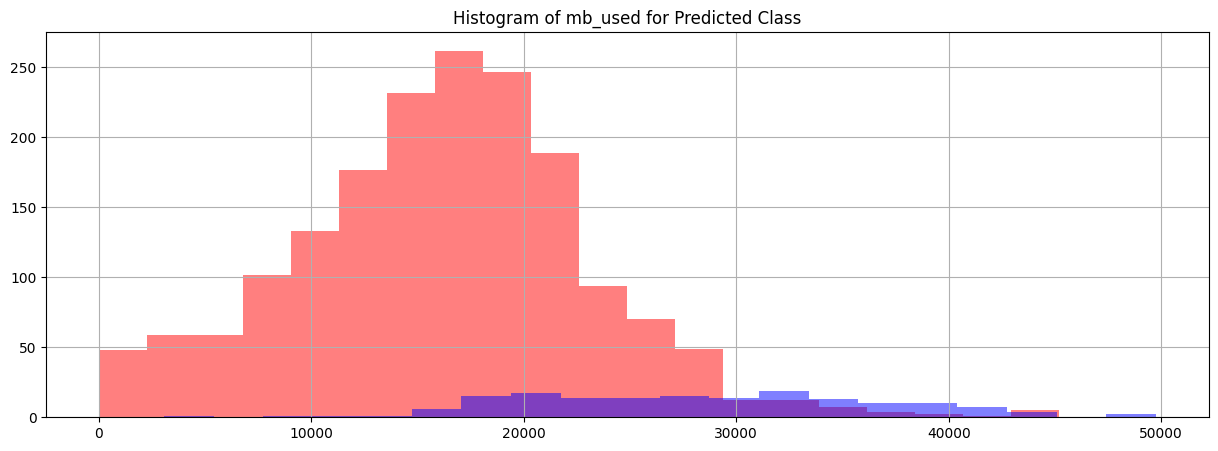

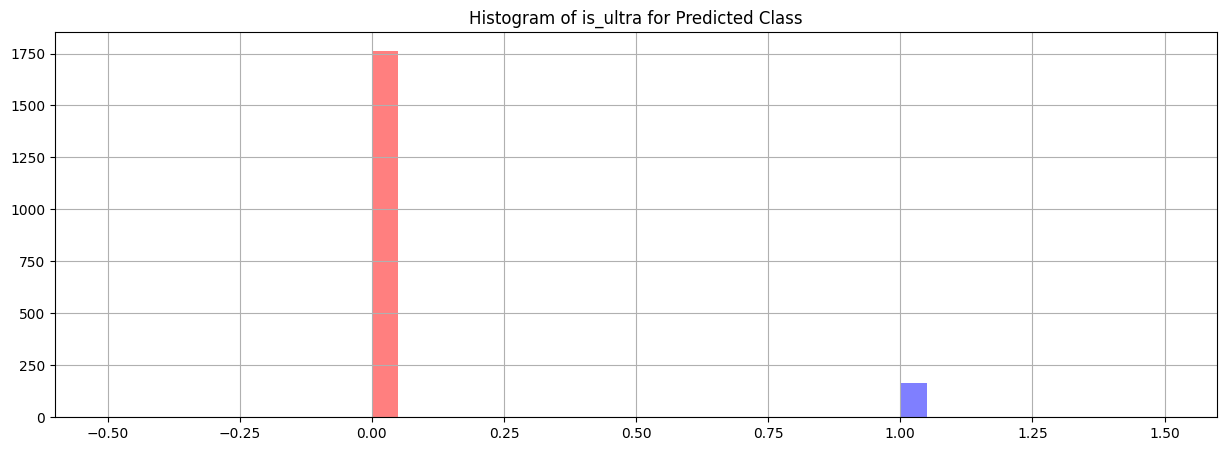

In [21]:
# This seems to validate the observation above
# When comparing to the actual data the model is underpredicting Ultra users

model0_df = X_train.copy().reset_index(drop=True) 
model0_df['is_ultra'] = pd.Series(model0_train_pred)  

model0_features = model0_df.columns.tolist()
for feature in model0_features:
    model0_df.query('is_ultra == 0')[feature].hist(figsize=[15,5], bins=20, color='r', alpha=0.5)
    model0_df.query('is_ultra == 1')[feature].hist(figsize=[15,5], bins=20, color='b', alpha=0.5)
    plt.title(f"Histogram of {feature} for Predicted Class")
    plt.show()

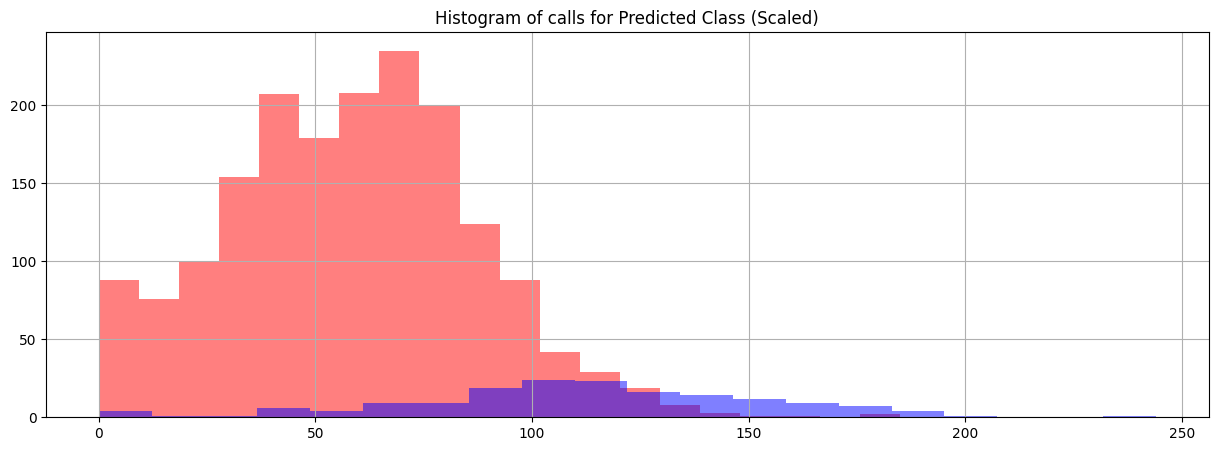

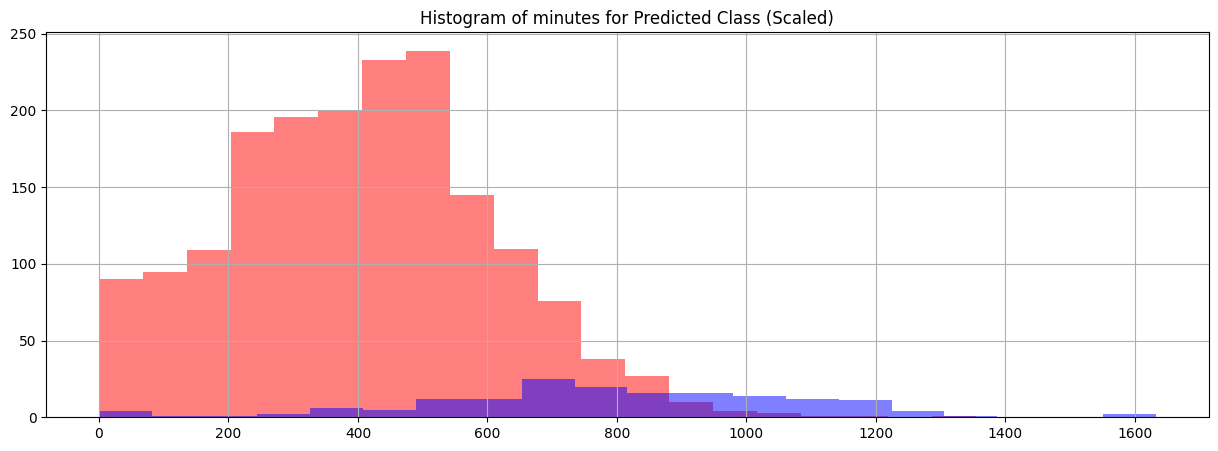

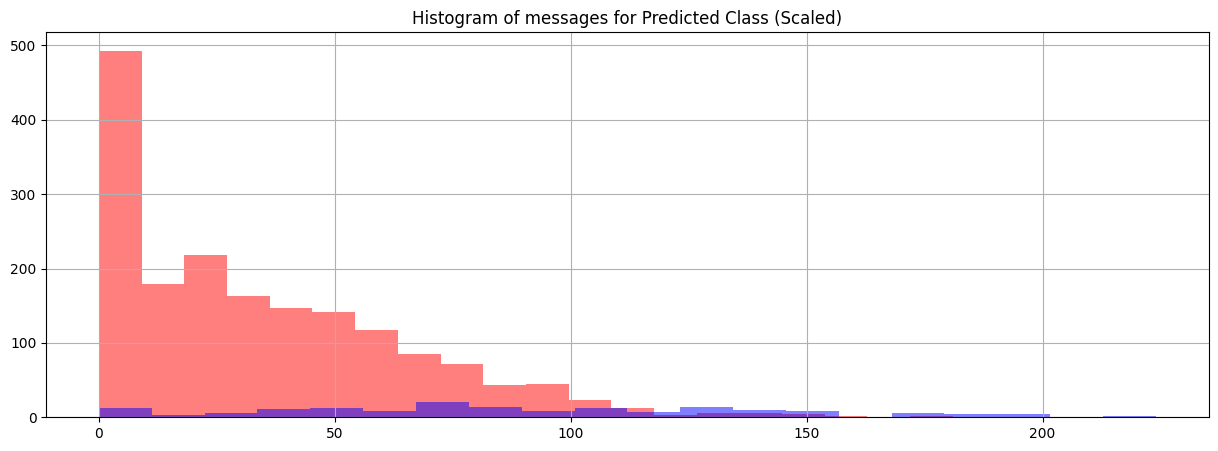

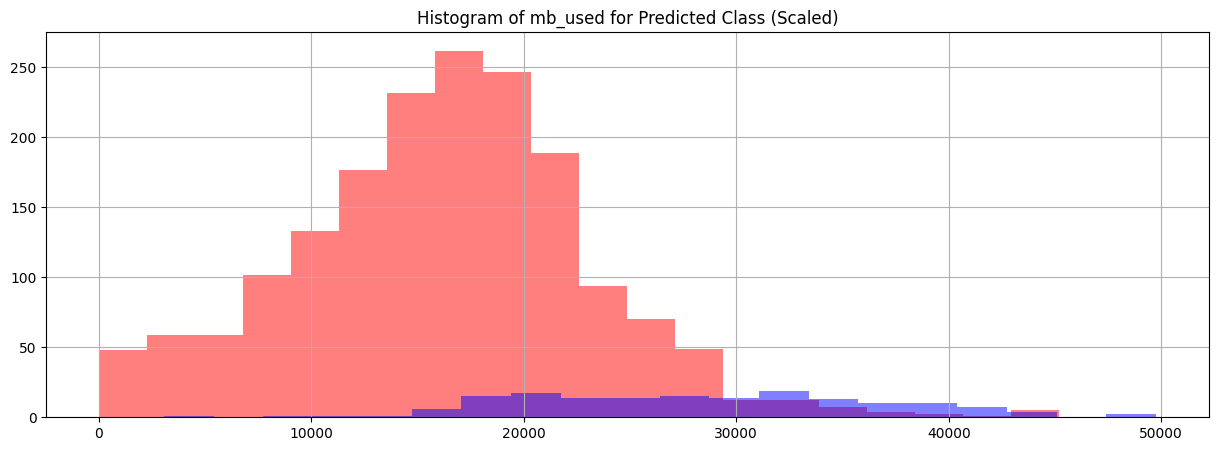

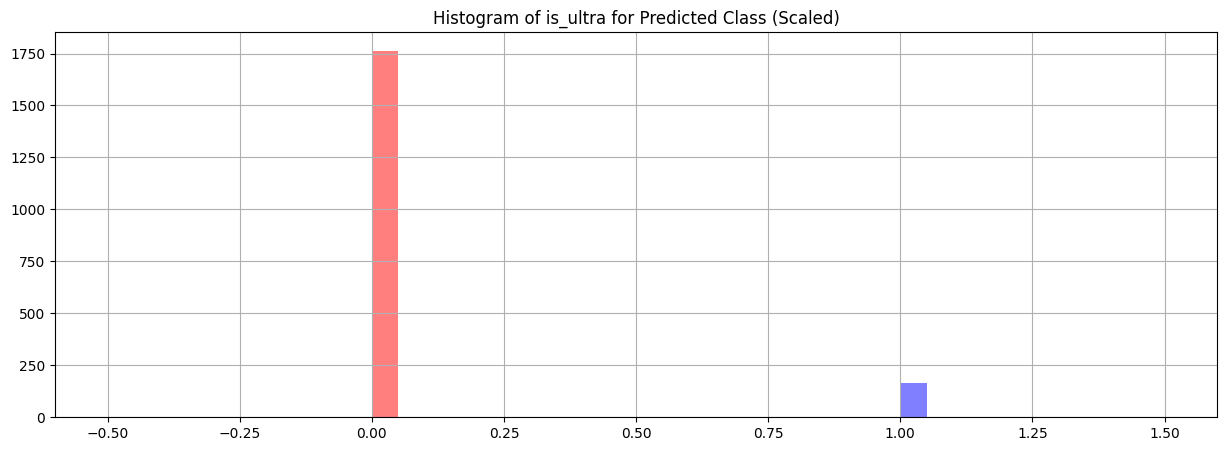

In [22]:
# Scaled data is similar 

scaled_model0_df = X_train.copy().reset_index(drop=True) 
scaled_model0_df['is_ultra'] = pd.Series(model0_train_pred)  

scaled_model0_features = scaled_model0_df.columns.tolist()
for feature in scaled_model0_features:
    scaled_model0_df.query('is_ultra == 0')[feature].hist(figsize=[15,5], bins=20, color='r', alpha=0.5)
    scaled_model0_df.query('is_ultra == 1')[feature].hist(figsize=[15,5], bins=20, color='b', alpha=0.5)
    plt.title(f"Histogram of {feature} for Predicted Class (Scaled)")
    plt.show()

**Logistic Regression Observations:** 
- Looks like logistic regression over-predicts Smart users since the feature distribution of a lot of ultra users overlap with Smart users. 
- Scaled data doesn't perform much better than unscaled data here.
- The histograms on training data shows that this model is underfitting ultra users - decision tree and random forest should perform better

### Decision Tree

In [23]:
# Iterative loop to find ideal depth:

best_result = 0
best_depth = 0

for i in range(1, 11):
    model = DecisionTreeClassifier(random_state=random_state, max_depth=i)
    model.fit(X_train, y_train)
    score = model.score(X_valid, y_valid)
    print(i, 'max depth accuracy:', f'{score:.1%}')
    if score > best_result:
        best_result = score
        best_depth = i

print("Accuracy of the best model:", f'{best_result:.1%}')
print("Depth of the best model:", best_depth)

1 max depth accuracy: 73.9%
2 max depth accuracy: 77.0%
3 max depth accuracy: 77.3%
4 max depth accuracy: 77.6%
5 max depth accuracy: 79.3%
6 max depth accuracy: 79.0%
7 max depth accuracy: 78.4%
8 max depth accuracy: 78.7%
9 max depth accuracy: 78.1%
10 max depth accuracy: 77.9%
Accuracy of the best model: 79.3%
Depth of the best model: 5


In [24]:
# Decision Tree Model
#     Training accuracy of 100% is really high, suggesting that this model overfit the trianing data
#     Recall and Precision are no better than a coin toss, suggesting the model is overfit

model1 = DecisionTreeClassifier(random_state=random_state, max_depth=best_depth)
model1.fit(X_train, y_train)

model1_train_pred = model1.predict(X_train)
model1_valid_pred = model1.predict(X_valid)

print('Training Set:')
print_eval_metrics(y_train, model1_train_pred)
print()
print('Validation Set:')
print_eval_metrics(y_valid, model1_valid_pred)

Training Set:
Accuracy: 81.9%
Recall: 52.3%
Precision: 83.2%
F1 Score: 64.2%

Validation Set:
Accuracy: 79.3%
Recall: 50.2%
Precision: 78.4%
F1 Score: 61.2%


In [25]:
# Using cross validation:

for metric in metrics:
    scores = cross_val_score(model1, X_train, y_train, cv=5, scoring=metric)
    print(f'{metric} scores:', scores)
    print(f'{metric} scores average:', f'{scores.mean():.1%}')
    print()

accuracy scores: [0.78238342 0.77720207 0.78238342 0.79220779 0.8       ]
accuracy scores average: 78.7%

recall scores: [0.45       0.43333333 0.475      0.4789916  0.50833333]
recall scores average: 46.9%

precision scores: [0.75       0.74285714 0.73076923 0.76       0.7721519 ]
precision scores average: 75.1%



In [26]:
# Taking a peek inside actual predictions:

print('Training Predictions:')
print_results_distribution(model1_train_pred)
print()
print('Validation Predictions:')
print_results_distribution(model1_valid_pred)

Training Predictions:
   count  proportion
0   1552    0.804979
1    376    0.195021

Validation Predictions:
   count  proportion
0    509    0.791602
1    134    0.208398


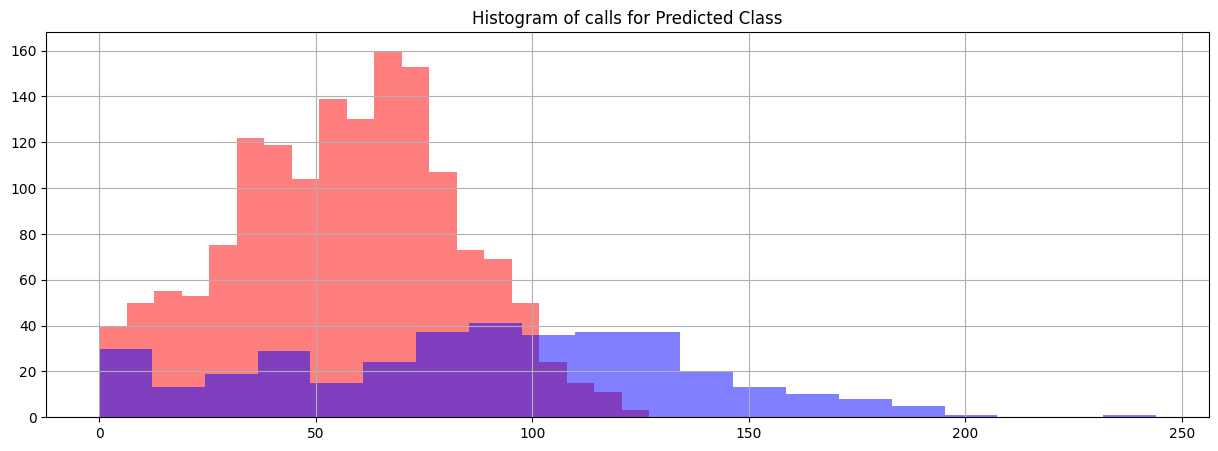

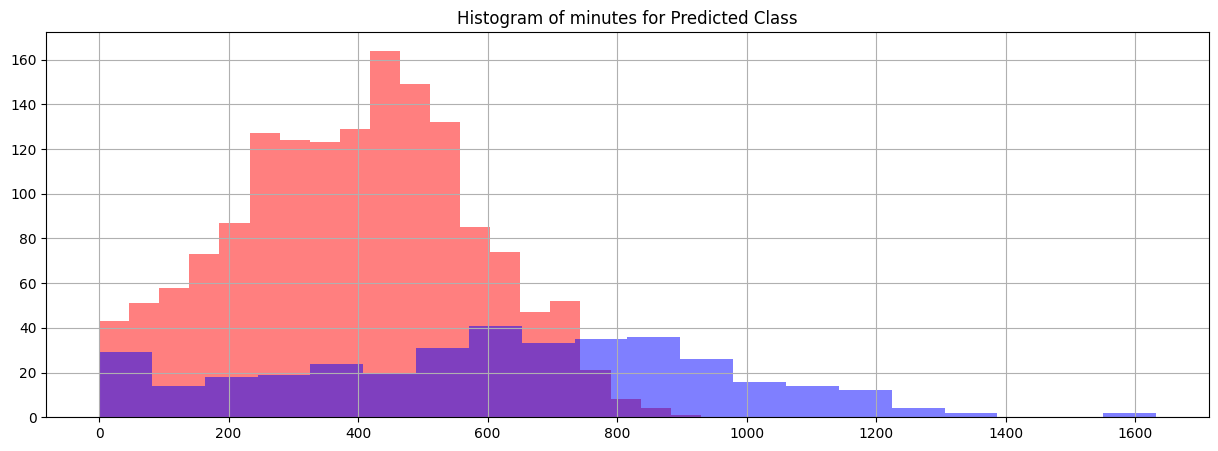

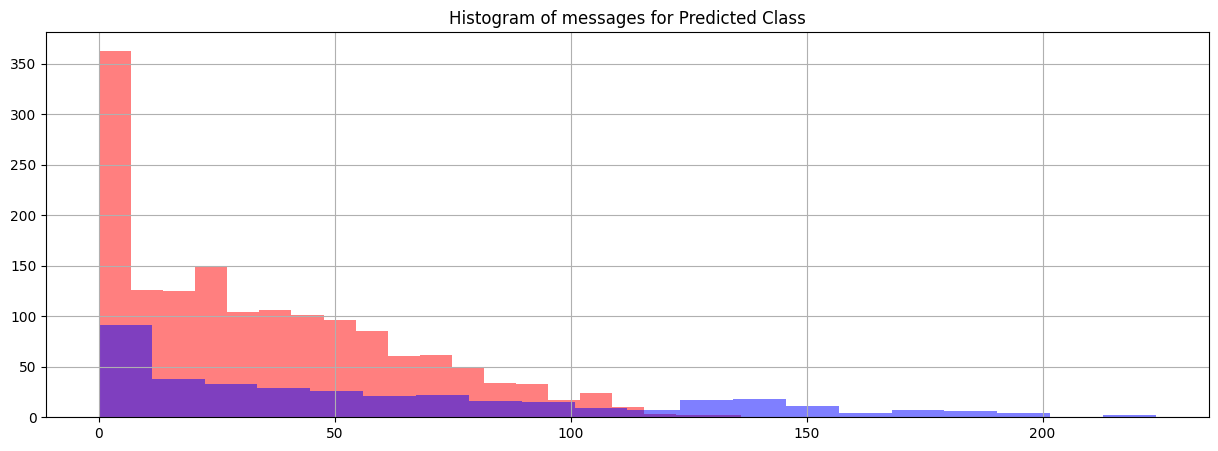

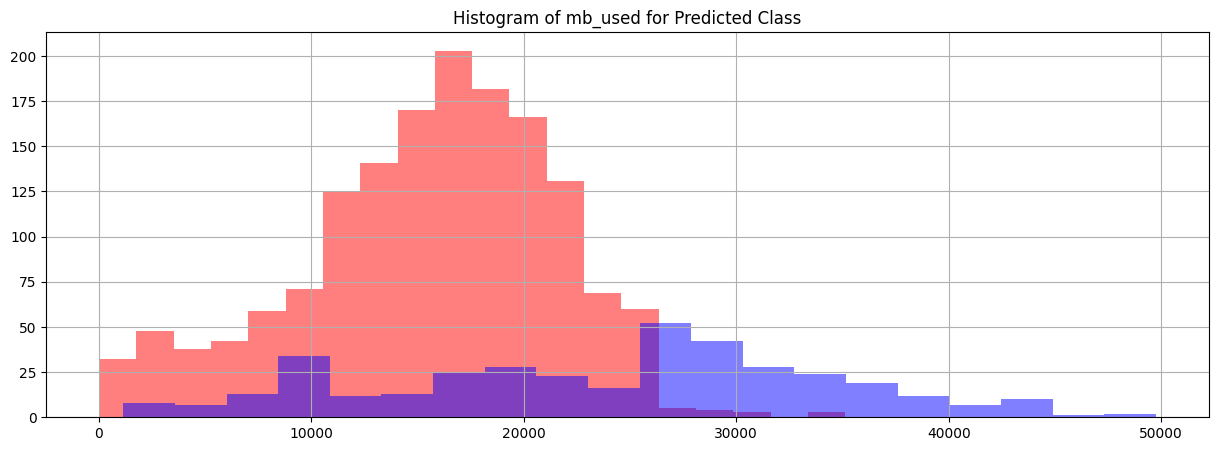

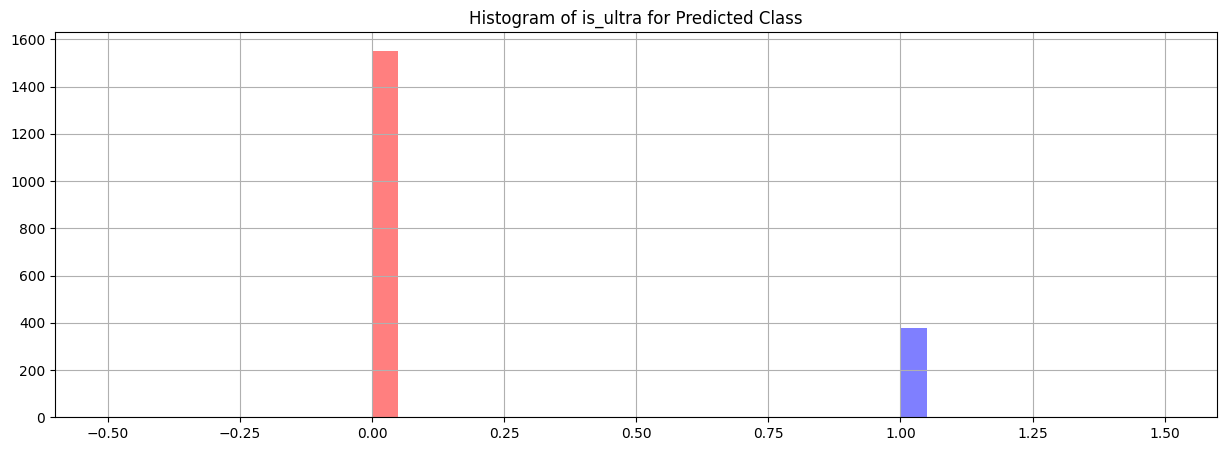

In [27]:
model1_df = X_train.copy().reset_index(drop=True) 
model1_df['is_ultra'] = pd.Series(model1_train_pred)  

model1_features = model1_df.columns.tolist()
for feature in model1_features:
    model1_df.query('is_ultra == 0')[feature].hist(figsize=[15,5], bins=20, color='r', alpha=0.5)
    model1_df.query('is_ultra == 1')[feature].hist(figsize=[15,5], bins=20, color='b', alpha=0.5)
    plt.title(f"Histogram of {feature} for Predicted Class")
    plt.show()

**Decision Tree Observations:**
- Decision Tree has a higher accuracy and does much better on recall than log regression
- These distributions look a bit better than Logistic Regression
- There is less over-predicting of the majority class than log regression, but it still occurs
- There is a risk of overfitting as we are using a deeper max tree depth, but it appears the model is still underfitting users as seen in the histograms of training set predictions

### Random Forest

In [28]:
# Iterative loop to find ideal depth:

best_result = 0
best_depth = 0

for i in range(1, 11):
    model = RandomForestClassifier(random_state=random_state, max_depth=i)
    model.fit(X_train, y_train)
    score = model.score(X_valid, y_valid)
    print(i, 'max depth accuracy:', f'{score:.1%}')
    if score > best_result:
        best_result = score
        best_depth = i

print("Accuracy of the best model:", f'{best_result:.1%}')
print("Depth of the best model:", best_depth)

1 max depth accuracy: 76.4%
2 max depth accuracy: 77.3%
3 max depth accuracy: 77.9%
4 max depth accuracy: 77.9%
5 max depth accuracy: 78.5%
6 max depth accuracy: 79.2%
7 max depth accuracy: 79.3%
8 max depth accuracy: 79.9%
9 max depth accuracy: 79.5%
10 max depth accuracy: 79.8%
Accuracy of the best model: 79.9%
Depth of the best model: 8


In [29]:
# Iterative loop to find ideal n_estimators:
#     Fed in the optimal tree depth from the prior cell

best_result = 0
best_est = 0

for i in range(1, 11):
    model = RandomForestClassifier(random_state=random_state, n_estimators=i, max_depth=best_depth)
    model.fit(X_train, y_train)
    score = model.score(X_valid, y_valid)
    print(i, 'estimators accuracy:', f'{score:.1%}')
    if score > best_result:
        best_result = score
        best_est = i

print("Accuracy of the best model:", f'{best_result:.1%}')
print("Estimators in the best model:", best_est)

1 estimators accuracy: 76.2%
2 estimators accuracy: 76.4%
3 estimators accuracy: 78.1%
4 estimators accuracy: 78.1%
5 estimators accuracy: 78.7%
6 estimators accuracy: 78.8%
7 estimators accuracy: 78.5%
8 estimators accuracy: 79.6%
9 estimators accuracy: 79.3%
10 estimators accuracy: 79.6%
Accuracy of the best model: 79.6%
Estimators in the best model: 8


In [30]:
# Random Forest Classifier Model
#     Not surprisingly Random Forest has the best accuracy, but it's recall is no better than a coin toss
#     Recall is the amount of Ultra users accurately predicted, Precision is the amount of predicted Ultra users that are correct
#     This means the model was under-predicting Ultra users, resulting in a higher precision but lower recall 

model2 = RandomForestClassifier(random_state=random_state, n_estimators=best_est)
model2.fit(X_train, y_train)

model2_train_pred = model2.predict(X_train)
model2_valid_pred = model2.predict(X_valid)

print('Training Set:')
print_eval_metrics(y_train, model2_train_pred)
print()
print('Validation Set:')
print_eval_metrics(y_valid, model2_valid_pred)

Training Set:
Accuracy: 96.9%
Recall: 91.3%
Precision: 98.7%
F1 Score: 94.9%

Validation Set:
Accuracy: 78.7%
Recall: 50.7%
Precision: 75.7%
F1 Score: 60.7%


In [31]:
# Using cross validation:

for metric in metrics:
    scores = cross_val_score(model2, X_train, y_train, cv=5, scoring=metric)
    print(f'{metric} scores:', scores)
    print(f'{metric} scores average:', f'{scores.mean():.1%}')
    print()

accuracy scores: [0.78756477 0.79274611 0.79792746 0.78181818 0.79220779]
accuracy scores average: 79.0%

recall scores: [0.49166667 0.49166667 0.55       0.48739496 0.55833333]
recall scores average: 51.6%

precision scores: [0.7375     0.75641026 0.73333333 0.71604938 0.71276596]
precision scores average: 73.1%



In [32]:
# Taking a peek inside actual predictions:

print('Training Predictions:')
print_results_distribution(model2_train_pred)
print()
print('Validation Predictions:')
print_results_distribution(model2_valid_pred)

Training Predictions:
   count  proportion
0   1374    0.712656
1    554    0.287344

Validation Predictions:
   count  proportion
0    503    0.782271
1    140    0.217729


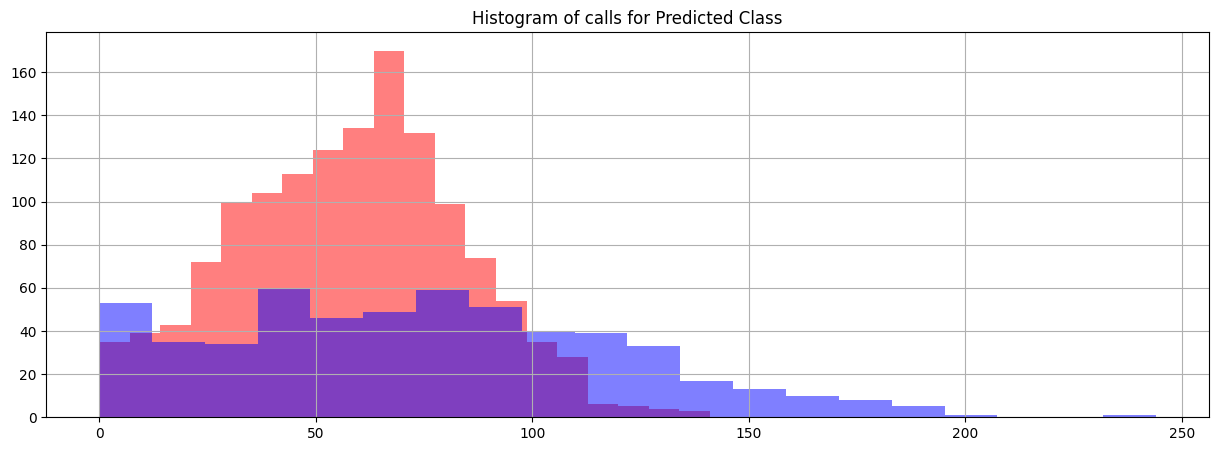

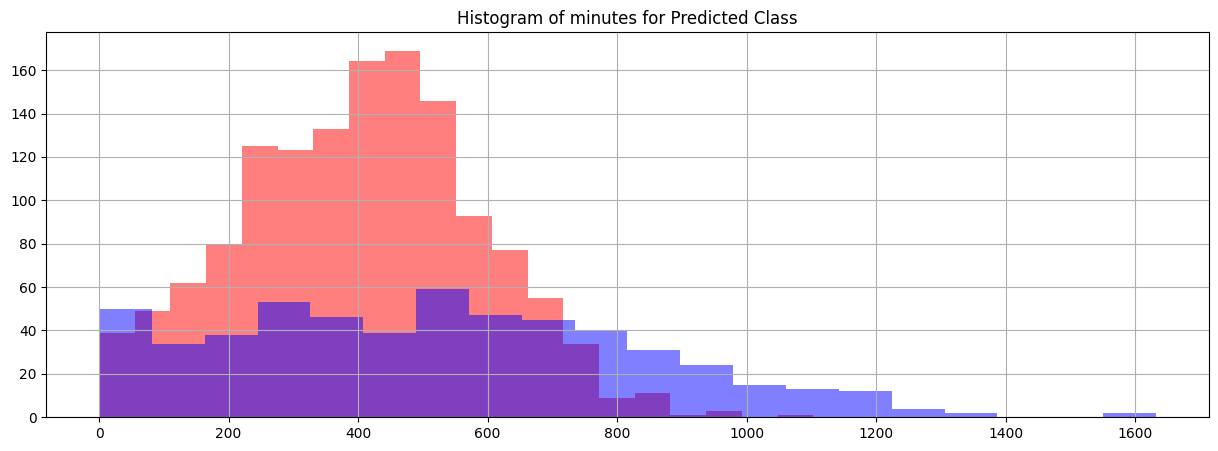

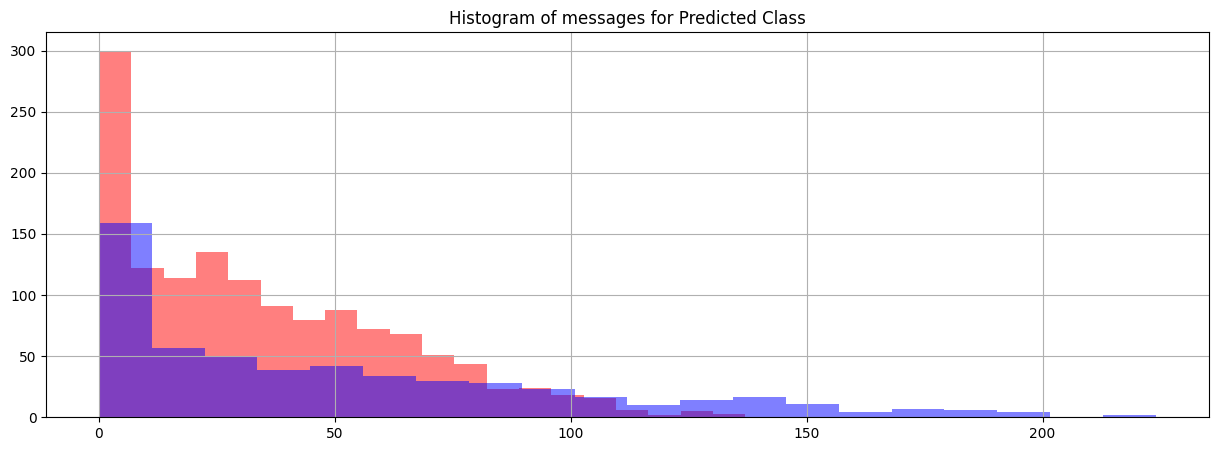

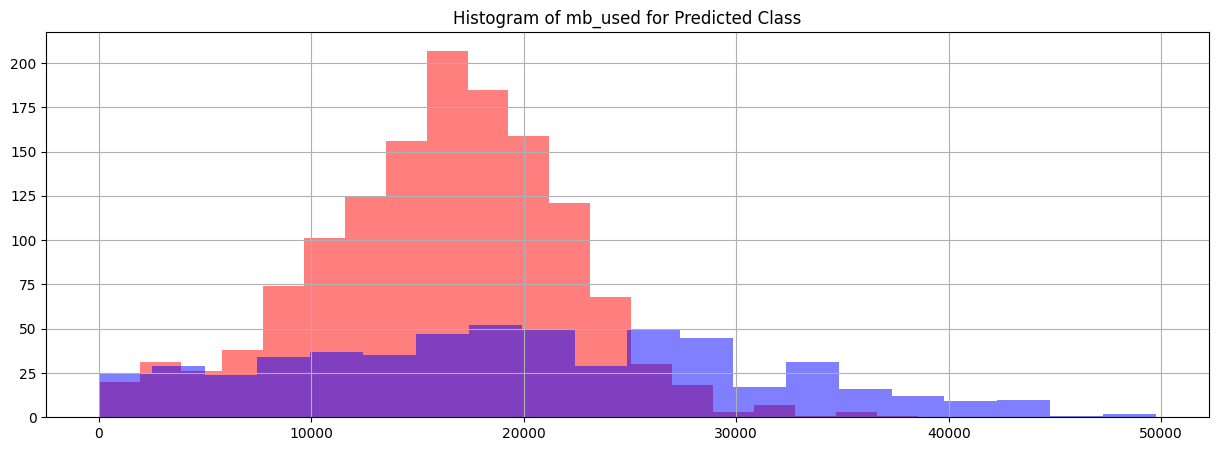

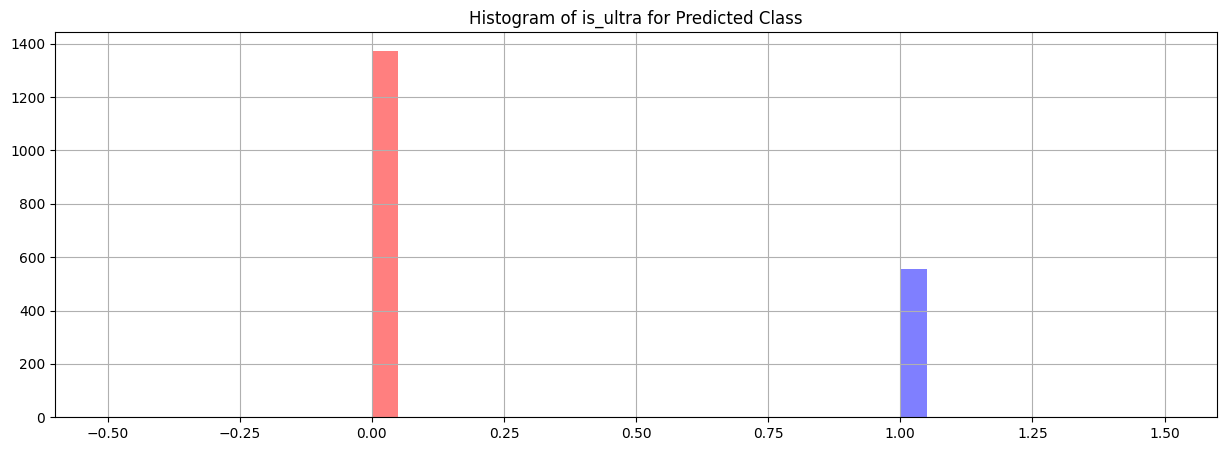

In [33]:
model2_df = X_train.copy().reset_index(drop=True) 
model2_df['is_ultra'] = pd.Series(model2_train_pred)  

model2_features = model2_df.columns.tolist()
for feature in model2_features:
    model2_df.query('is_ultra == 0')[feature].hist(figsize=[15,5], bins=20, color='r', alpha=0.5)
    model2_df.query('is_ultra == 1')[feature].hist(figsize=[15,5], bins=20, color='b', alpha=0.5)
    plt.title(f"Histogram of {feature} for Predicted Class")
    plt.show()

**Random Forest Observations:**
- Random Forest does better than decision tree on recall but has lower preceision (the F1 is about equal) 
- The accuracy is about the same (minutely lower)
- This means random forest predicts more Ultra users, which increases its recall but decreases its precision because it is not getting all of the addition Ultra predictions right 
- The distribution of features for predicted class looks a lot closer to actual values than the other models (training data shown in the histograms)
- This model predicts the closest to actual data in terms of proportion of ultra users 

### Modeling Results
- We need to take business objective and risks into account when choosing the right model 
- This task (recommending a plan to upgrade to) seems to be relatively low risk to get wrong (noone dies), but may result in lower revenue if users that would've been on Ultra instead upgrade to Smart (assuming Ultra costs more than Smart)
- There may be factors (such as personal preferences) that we can't see which cause users to choose plans
- While the preformance in terms of accuracy is about the same as decision tree (a bit lower), I would opt for this model as it has a more reflective proportion of users and has a more even balance of recall vs. precision 
- If the goal of the recommendation is to get as many users to upgrade as possible, and to maximize revenue, then having a more reflective and higher proportion of Ultra recommendations seems the better choice to make when accuracy is similar
- Assuming Ultra users pay more, having a higher recall would outweigh having slightly lower accuracy in terms of revenue since the additional income from Ultra users would offset the inaccurate recommendations

## Model Testing
- Since we don't have actual test data, we are using the 20% of data reserved as a test set here
- Comparing all three models just to see results

In [34]:
model0_test_pred = model0.predict(X_test)
model1_test_pred = model1.predict(X_test)
model2_test_pred = model2.predict(X_test)

print('Logistic Regression:')
print_eval_metrics(y_test, model0_test_pred)
print()
print('Decision Tree:')
print_eval_metrics(y_test, model1_test_pred)
print()
print('Random Forest:')
print_eval_metrics(y_test, model2_test_pred)

Logistic Regression:
Accuracy: 76.7%
Recall: 19.8%
Precision: 81.4%
F1 Score: 31.8%

Decision Tree:
Accuracy: 80.7%
Recall: 44.1%
Precision: 75.7%
F1 Score: 55.7%

Random Forest:
Accuracy: 79.9%
Recall: 47.5%
Precision: 70.0%
F1 Score: 56.6%


### Sanity Checking Test Results
- Using the same methods: K-fold, checking proportions and distributions

In [35]:
# Using cross validation: 
#     Looks good as the scores are all around the same range

for metric in metrics:
    scores = cross_val_score(model1, X, y, cv=5, scoring=metric)
    print(f'Decision Tree {metric} scores:', scores)
    print(f'Decision Tree {metric} scores average:', f'{scores.mean():.1%}')
    print()

print('---', end='\n\n')
    
for metric in metrics:
    scores = cross_val_score(model2, X, y, cv=5, scoring=metric)
    print(f'Random Forest {metric} scores:', scores)
    print(f'Random Forest {metric} scores average:', f'{scores.mean():.1%}')
    print()

Decision Tree accuracy scores: [0.78382582 0.7807154  0.79937792 0.79315708 0.78037383]
Decision Tree accuracy scores average: 78.7%

Decision Tree recall scores: [0.43654822 0.42639594 0.43147208 0.45177665 0.38071066]
Decision Tree recall scores average: 42.5%

Decision Tree precision scores: [0.75438596 0.75       0.83333333 0.78070175 0.79787234]
Decision Tree precision scores average: 78.3%

---

Random Forest accuracy scores: [0.79471229 0.75583204 0.80248834 0.79004666 0.80529595]
Random Forest accuracy scores average: 79.0%

Random Forest recall scores: [0.52791878 0.45177665 0.55329949 0.56345178 0.53807107]
Random Forest recall scores average: 52.7%

Random Forest precision scores: [0.72727273 0.64492754 0.73648649 0.69375    0.75714286]
Random Forest precision scores average: 71.2%



In [36]:
# Checking proportions:

print('Test Predictions:')
print_results_distribution(model2_test_pred)

Test Predictions:
   count  proportion
0    523    0.813375
1    120    0.186625


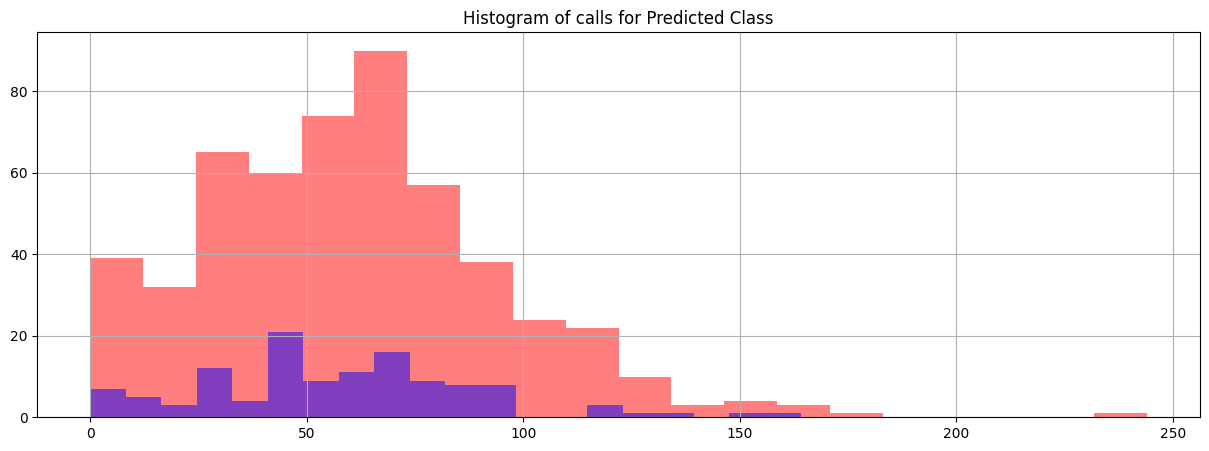

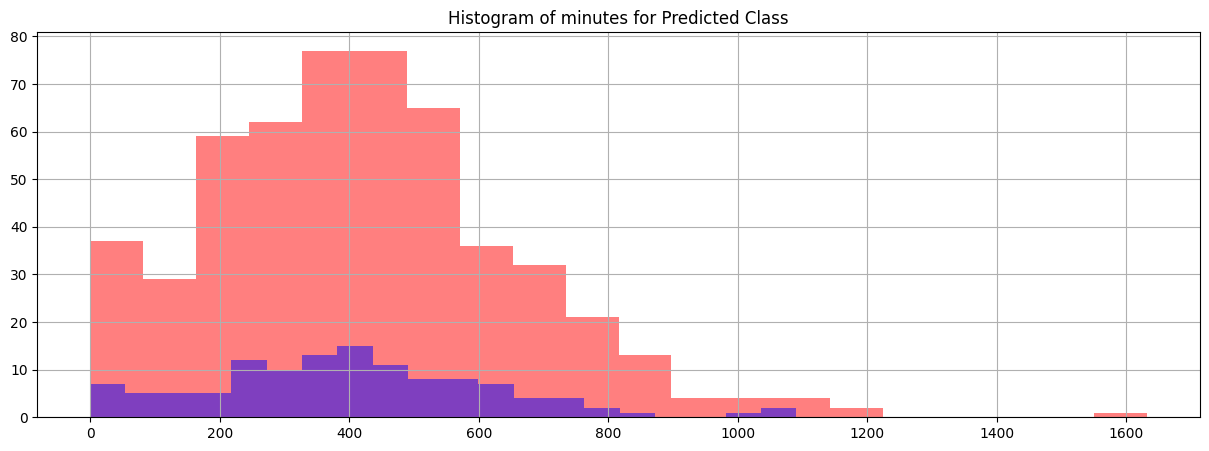

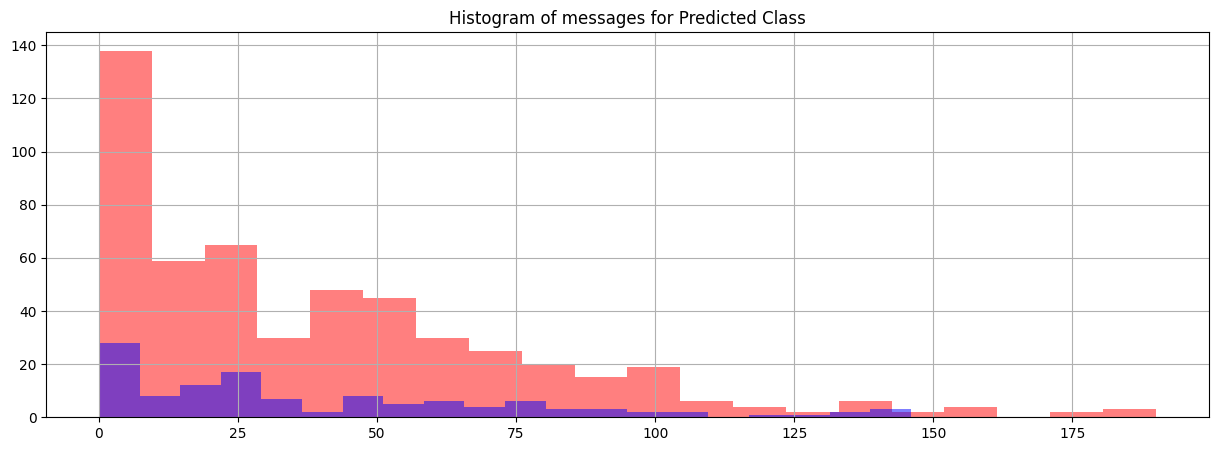

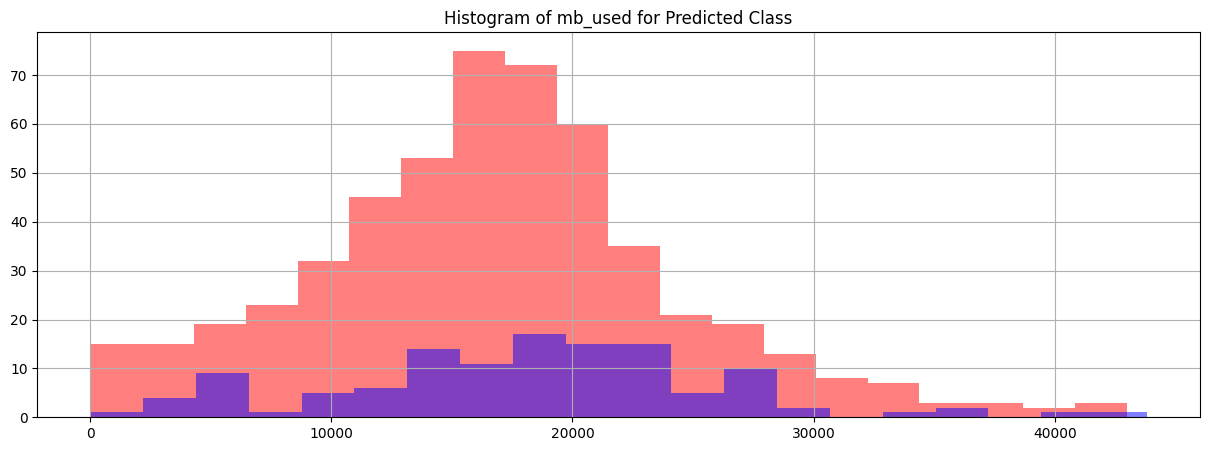

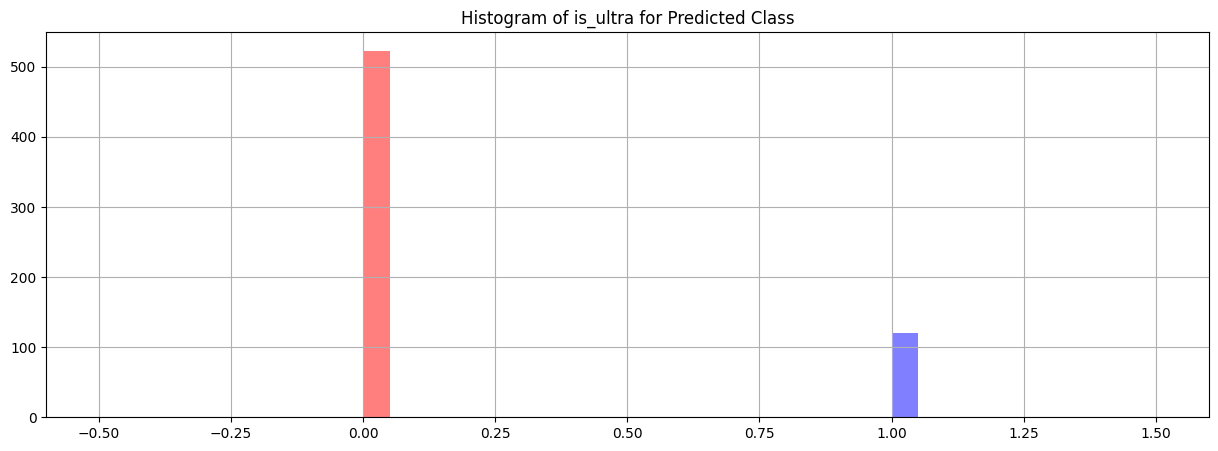

In [37]:
model2_df = X_train.copy().reset_index(drop=True) 
model2_df['is_ultra'] = pd.Series(model2_test_pred)  

model2_features = model2_df.columns.tolist()
for feature in model2_features:
    model2_df.query('is_ultra == 0')[feature].hist(figsize=[15,5], bins=20, color='r', alpha=0.5)
    model2_df.query('is_ultra == 1')[feature].hist(figsize=[15,5], bins=20, color='b', alpha=0.5)
    plt.title(f"Histogram of {feature} for Predicted Class")
    plt.show()

### Final Observations
- Both the decision tree and random forest pass the 75% accuracy threshold, and outperform the baseline model
- While decision tree is higher in terms of accuracy, random forest has higher recall (how many real Ultra users were predicted correctly), with over 50% 
- This means the random forest recommendation method would result in higher revenues assuming Ultra pays more and that correctly predicted users convert 
- The random forest model still underpredicts Ultra users, but does a better job than the other 2 models
- If we were to build on this analysis, we could look into additional features that show a greater difference between Smart and Ultra users. The 4 features used in this analysis had a lot of overlap for the majority of Smart and Ultra users in terms of usage behavior